In [29]:
!pip install torch torchvision livelossplot wandb torchtyping tqdm pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


## Libraries

In [22]:
import sys
import os
# Add spectroscope to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [30]:
from typing import Any, Tuple, Type
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
from torchtyping import TensorType
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from livelossplot import PlotLosses
from tqdm.notebook import tqdm
import pandas as pd

from spectroscope.data import SubsetsLoader, get_filtered_dataset

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")

# Data

In [ ]:
# Load the data
mnist_train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

## Simple ConvNet

This an unmodified mnist learner

In [ ]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 4 * 4, 10)

        self.to(DEVICE)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

# START OF IDEA: Introduction of new digits in training

The section aims to see if introducing new digits later in the Epoch gives discontinuous boosts in peformance. I expect it shouldn't, since if we have the model say learn just 0 and 1 in the first half of training, then introduce the number 2, the parameters will be fitted only to (0,1) and do terrible on 2, so I expect a massive dip in accuracy in the middle, then some recovery at the end once it's seen some 0,1,2s but nowhere near the 90%+ as if we just did all 10 from the start. It's highly possible I may have misunderstood the setup, since I don't see how this could give a phase transition in decrease of loss. 

The code below is simply testing the filter digit function does as expected

In [ ]:
def as_subset(cls: Type[Dataset]):
    """
    Wrapper for a dataset class that adds a labels attribute to the dataset,
    and a __repr__ method that prints the labels.
    """
    class Subset(cls):
        def __init__(self, data, targets, train: bool, labels: Tuple[int, ...], **kwargs):
            self.labels = labels
            self.data = data
            self.targets = targets

            self.train = train

        def __len__(self):
            return len(self.data)

        def __repr__(self):
            return f"Subset({cls.__name__}, len={len(self)}, labels={self.labels})"
        
        def __getitem__(self, index: int) -> Tuple[Any, Any]:
            """
            Args:
                index (int): Index

            Returns:
                tuple: (image, target) where target is index of the target class.
            """
            return self.data[index], int(self.targets[index])
    
    return Subset


def filter_by_labels(dataset: Dataset, labels: Tuple[int, ...]):
    """
    Returns an iterator over the dataset, yielding only the images and labels in labels.
    """
    for image, label in dataset:
        if label in labels:
            yield image, label


def get_filtered_dataset(dataset: Dataset, labels: Tuple[int, ...]):
    """
    Returns a new dataset with only the images and labels in labels.
    """
    dataset_cls = as_subset(type(dataset))
    data, targets = zip(*((x, y) for x, y in filter_by_labels(dataset, labels)))
    return dataset_cls(data, targets, train=dataset.train, labels=labels)  # type: ignore


class SubsetsLoader:
    """
    A data loader that trains on different subsets of the dataset 
    depending on the active subset.

    Note: it's up to you to call next_subset() when you want to move to the next subset.
    """

    def __init__(
        self,
        subsets: Tuple[Dataset],
        *args,
        **kwargs,
    ):
        self.subsets = subsets
        self.subset_idx = 0
        self.subloaders = tuple(DataLoader(subset, *args, **kwargs) for subset in subsets)

    def next_subset(self):
        """Moves to the next subset."""
        if self.subset_idx < len(self.subsets):
            self.subset_idx += 1
        else:
            raise StopIteration
         
    def to_subset(self, subset_idx: int):
        """Moves to the subset with index subset_idx."""
        if subset_idx < len(self.subsets):
            self.subset_idx = subset_idx
        else:
            raise IndexError(f"Subset index {subset_idx} out of range")
    
    @property
    def dataset(self):
        return self.subsets[self.subset_idx]
    
    @property
    def loader(self):
        return self.subloaders[self.subset_idx]
    
    @property
    def batch_size(self):
        return self.loader.batch_size

    @classmethod
    def from_filters(cls, dataset: Dataset, labels_per_subset: Tuple[Tuple[int, ...]], **kwargs):
        """
        Returns a SubsetsLoader that trains on different subsets of the dataset 
        depending on the active subset.
        """
        subsets = tuple(get_filtered_dataset(dataset, labels) for labels in labels_per_subset)
        return cls(subsets, **kwargs)
        
    def __repr__(self):
        return f"SubsetsLoader({self.subsets}, batch_size={self.batch_size})"
    
    def __iter__(self):
        return iter(self.subloaders[self.subset_idx])

    def __len__(self):
        return len(self.dataset)

subsets_loader = SubsetsLoader.from_filters(
    mnist_train,
    labels_per_subset=tuple(tuple(range(i+1)) for i in range(0, 10)),
    batch_size=256,
    shuffle=True, 
)

subsets_loader

SubsetsLoader((Subset(MNIST, len=5923, labels=(0,)), Subset(MNIST, len=12665, labels=(0, 1)), Subset(MNIST, len=18623, labels=(0, 1, 2)), Subset(MNIST, len=24754, labels=(0, 1, 2, 3)), Subset(MNIST, len=30596, labels=(0, 1, 2, 3, 4)), Subset(MNIST, len=36017, labels=(0, 1, 2, 3, 4, 5)), Subset(MNIST, len=41935, labels=(0, 1, 2, 3, 4, 5, 6)), Subset(MNIST, len=48200, labels=(0, 1, 2, 3, 4, 5, 6, 7)), Subset(MNIST, len=54051, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8)), Subset(MNIST, len=60000, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))), batch_size=256)

In [ ]:
per_label_train_loader = SubsetsLoader.from_filters(
    mnist_train,
    labels_per_subset=tuple((i,) for i in range(0, 10)),
    batch_size=256,
)

per_label_test_loader = SubsetsLoader.from_filters(
    mnist_test,
    labels_per_subset=tuple((i,) for i in range(0, 10)),
    batch_size=256,
)

In [ ]:
class Metrics:
    def __init__(self, per_label_train_loader, per_label_test_loader, loss_fn):
        self.per_label_train_loader = per_label_train_loader
        self.per_label_test_loader = per_label_test_loader
        self.loss_fn = loss_fn

        # Track loss & accuracy for each label
        self.train_loss = t.zeros(10, dtype=t.float32, device=DEVICE)
        self.train_accuracy = t.zeros(10, dtype=t.float32, device=DEVICE)
        self.test_loss = t.zeros(10, dtype=t.float32, device=DEVICE)
        self.test_accuracy = t.zeros(10, dtype=t.float32, device=DEVICE)

        # Needed to compute the total loss & accuracy (so each subloss is weighted by the size of the subset)
        self.trainset_sizes = t.tensor([len(subset) for subset in per_label_train_loader.subsets], device=DEVICE)
        self.testset_sizes = t.tensor([len(subset) for subset in per_label_test_loader.subsets], device=DEVICE)

    def measure(self, model: nn.Module):
        with t.no_grad():
            # Loop over each specific-label-restricted subset of data
            for l in tqdm(range(10), desc="Measuring metrics"):
                self.per_label_train_loader.to_subset(l)
                self.per_label_test_loader.to_subset(l)

                for i, (x, y) in enumerate(self.per_label_train_loader):
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    y_pred = model(x)
                    predicted = t.argmax(y_pred, dim=1)
                    self.train_accuracy[l] += (predicted == y).sum()
                    self.train_loss[l] += self.loss_fn(y_pred, y)

                self.train_accuracy[l] /= self.trainset_sizes[l]
                self.train_loss[l] /= self.trainset_sizes[l]

                for i, (x, y) in enumerate(self.per_label_test_loader):
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    y_pred = model(x)
                    predicted = t.argmax(y_pred, dim=1)
                    self.test_accuracy[l] += (predicted == y).sum()
                    self.test_loss[l] += self.loss_fn(y_pred, y) 

                self.test_accuracy[l] /= self.testset_sizes[l]
                self.test_loss[l] /= self.testset_sizes[l]

    def reset(self):
        self.train_loss *= 0
        self.train_accuracy *= 0
        self.test_loss *= 0
        self.test_accuracy *= 0

    @property
    def total_train_size(self):
        return self.trainset_sizes.sum() 
    
    @property
    def total_test_size(self):
        return self.testset_sizes.sum()

    @property
    def total_train_loss(self):
        return (self.train_loss * self.trainset_sizes).sum() / self.total_train_size
    
    @property
    def total_test_loss(self):
        return (self.test_loss * self.testset_sizes).sum() / self.total_test_size

    @property
    def total_train_accuracy(self):
        return (self.train_accuracy * self.trainset_sizes).sum() / self.total_train_size
    
    @property
    def total_test_accuracy(self):
        return (self.test_accuracy * self.testset_sizes).sum() / self.total_test_size

    def as_dict(self):
        d = {
            "train/loss/total": self.total_train_loss,
            "test/loss/total": self.total_test_loss,
            "train/accuracy/total": self.total_train_accuracy,
            "test/accuracy/total": self.total_test_accuracy,
        }

        for l in range(10):
            d[f"train/loss/{l}"] = self.train_loss[l]
            d[f"test/loss/{l}"] = self.test_loss[l]
            d[f"train/accuracy/{l}"] = self.train_accuracy[l]
            d[f"test/accuracy/{l}"] = self.test_accuracy[l]

        return d      

Now we check whether we still get good accuracy with only 0, 1 and 2 in the dataset


So as we can see we still get good accuracy with less digits, althought there appears to be much more variation in the accuracy which was not expected, and that it takes longer to get to a good accuracy which doesnt make much sense to me. Now we will try to train this model to learn on 0s and 1s only, then we introduce 2 halfway into the second half of training (Epoch 50) to see if there is discontinuity in performance

In [26]:
import wandb

def train(model: nn.Module, loss_fn, optimizer, subsets_loader: SubsetsLoader, metrics: Metrics):
    wandb.init("detecting-phase-transitions")

    epoch = 0
    step = 0

    subsets_loader.to_subset(0)

    def measure(step):
        metrics.reset()
        metrics.measure(model)
        wandb.log(metrics.as_dict(), step=step)

    def save(step):
        t.save(model.state_dict(), f"./snapshots/model-{step}.pt")
    
    # Epochs change in size, so we want to keep the number of steps constant between changes
    for epoch in tqdm(range(100), desc="Epochs"): 
        train_loss = 0.
        
        if epoch % 10 == 0 and step > 0:
            subsets_loader.next_subset()
            print("Next subset:", subsets_loader.dataset)

        # Round to the nearest multiple of 24
        num_steps = len(subsets_loader)
        num_steps = (num_steps // 24) * 24

        # Training loop for mini-batches
        for batch_idx, (x, y) in tqdm(enumerate(subsets_loader), desc="Mini-batches", total=num_steps):            
            if step % 24 == 0:
                measure(step)
                save(step)
            
            # Make predictions with the current parameters.
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)

            # Compute the loss value.
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Update the parameters.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1

            if batch_idx == num_steps:
                break

    wandb.finish()

model = MNISTConvNet()
loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
metrics = Metrics(per_label_train_loader, per_label_test_loader, loss_fn)

train(model, loss_fn, optimizer, subsets_loader, metrics)

/home/paperspace/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


test/accuracy/0,███▁█▁██████████████████████████████████
test/accuracy/1,▁▁▁█▁███████████████████████████████████
test/accuracy/2,▁▁▁▁▁▁▁▁▇██████▇████████████████████████
test/accuracy/3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████████████████
test/accuracy/4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████
test/accuracy/5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
test/accuracy/6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy/7,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy/8,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy/9,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy/total,▁▁▁▁▁▁▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/5904 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=12665, labels=(0, 1))


Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/12648 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=18623, labels=(0, 1, 2))


Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/18600 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=24754, labels=(0, 1, 2, 3))


Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/24744 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=30596, labels=(0, 1, 2, 3, 4))


Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/30576 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=36017, labels=(0, 1, 2, 3, 4, 5))


Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/36000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=41935, labels=(0, 1, 2, 3, 4, 5, 6))


Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/41928 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=48200, labels=(0, 1, 2, 3, 4, 5, 6, 7))


Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/48192 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=54051, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8))


Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/54048 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Next subset: Subset(MNIST, len=60000, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))


Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Mini-batches:   0%|          | 0/60000 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Measuring metrics:   0%|          | 0/10 [00:00<?, ?it/s]

test/accuracy/0,██▁▆▇▆▇▇▇▇▇▇▇▇▇█▆▇▆▇▅▇▇▆▇▇▇▆▇▆▆▇▇▇▇▇▆▇▇▇
test/accuracy/1,▁███████████████████████████████████████
test/accuracy/2,▁▁▇█████████████████████████████████████
test/accuracy/3,▁▁▁▁▁███████████████████████████████████
test/accuracy/4,▁▁▁▁▁▁▁█████████████████████████████████
test/accuracy/5,▁▁▁▁▁▁▁▁▁▁▁▁████████████████████████████
test/accuracy/6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████████
test/accuracy/7,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
test/accuracy/8,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████
test/accuracy/9,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████
test/accuracy/total,▁▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████


# Structural probes

In [39]:
from typing import Iterable


NUM_STEPS = 792
IVL = 24

class WeightsAssay:
    def measure(self, cls: Type[MNISTConvNet], steps: Iterable[int]):
        model = cls() 
        measurements = []

        for i in steps:
            # Load model from snapshot
            model.load_state_dict(t.load(f"./snapshots/model-{i}.pt"))

            # Measure metrics
            measurements.append(self._measure(model, i))

        return pd.DataFrame(measurements)
    
    def _measure(self, model, step):
        weight_norms = self.weight_norms(model)

        return {
            "step": step,
            "weight_norms": weight_norms,
            "total_weight_norm": sum([wn ** 2 for wn in weight_norms]) ** 0.5,
            # "last_layer_rank": self.last_layer_rank(model),
        }
    
    @classmethod
    def weight_norms(cls, model: nn.Module):
        norms = []

        for p in model.parameters():
            norms.append(p.norm().item())

        return norms

    # @classmethod
    # def last_layer_rank(cls, model: nn.Module):
    #     return t.linalg.matrix_rank(model.fc1.weight).item()
    # NOTE Nevermind this is full rank

    # TODO: Add more probes

weights_assay = WeightsAssay()
measurements = weights_assay.measure(MNISTConvNet, range(0, NUM_STEPS, IVL))
measurements

,step,weight_norms,total_weight_norm,last_layer_rank
0,0,"[1.5633426904678345, 0.3008549213409424, 2.324...",3.337336,10
1,24,"[1.649056315422058, 0.3014752268791199, 2.3842...",3.482064,10
2,48,"[1.6596497297286987, 0.3068156838417053, 2.392...",3.499720,10
3,72,"[1.6646157503128052, 0.30970799922943115, 2.39...",3.508096,10
4,96,"[1.6678569316864014, 0.31172940135002136, 2.39...",3.513599,10
5,120,"[1.6702563762664795, 0.3132935166358948, 2.400...",3.517691,10
6,144,"[1.6721563339233398, 0.3145730495452881, 2.401...",3.520943,10
7,168,"[1.673725962638855, 0.31565818190574646, 2.403...",3.523638,10
8,192,"[1.6750614643096924, 0.316601425409317, 2.4042...",3.525936,10
9,216,"[1.676222801208496, 0.31743648648262024, 2.405...",3.527939,10


<AxesSubplot: xlabel='step'>

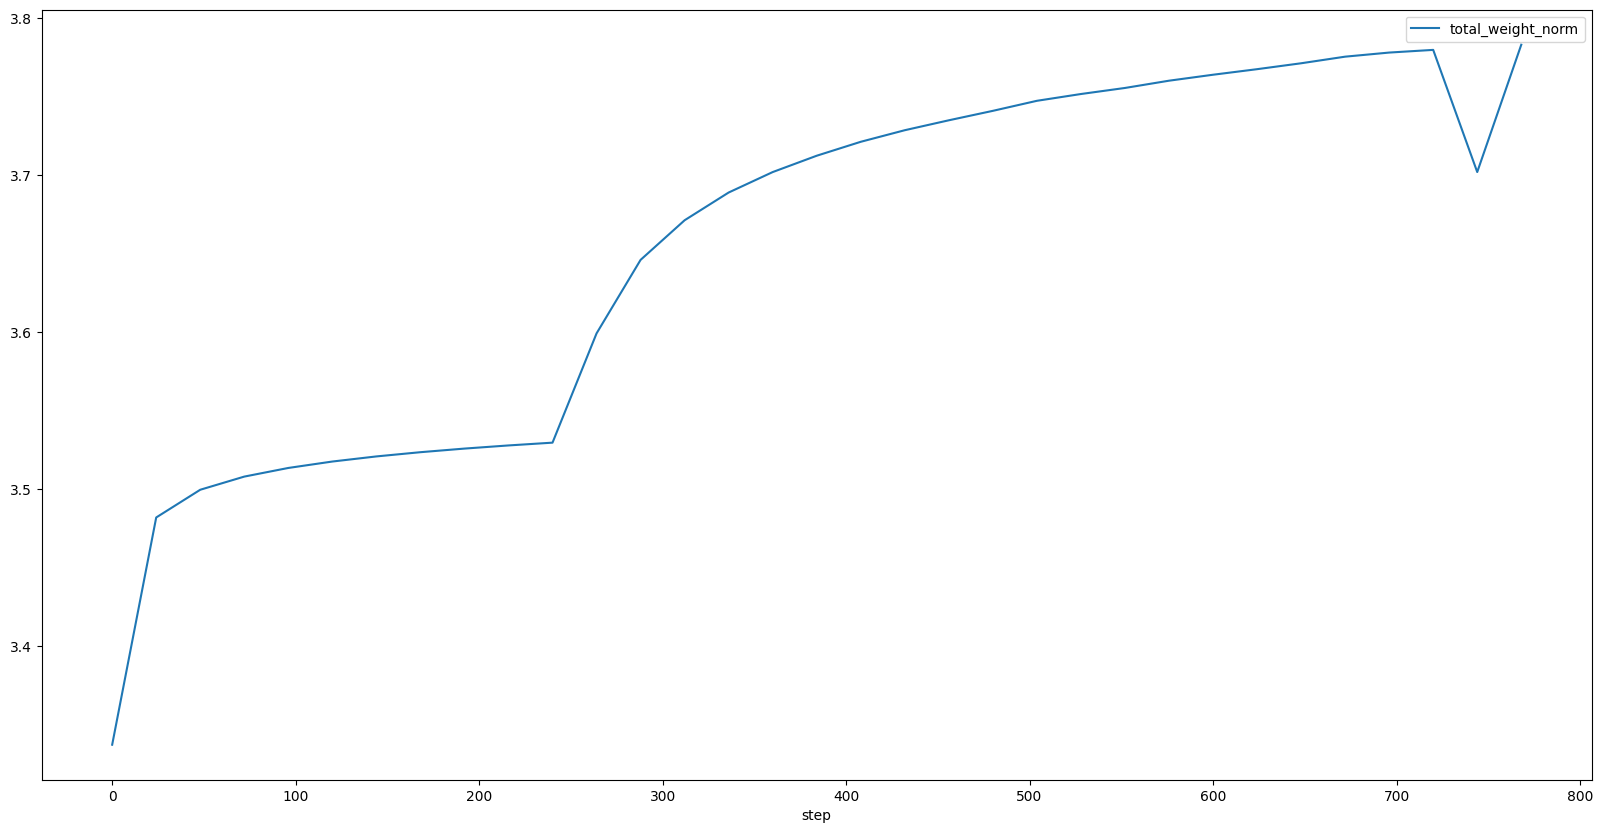

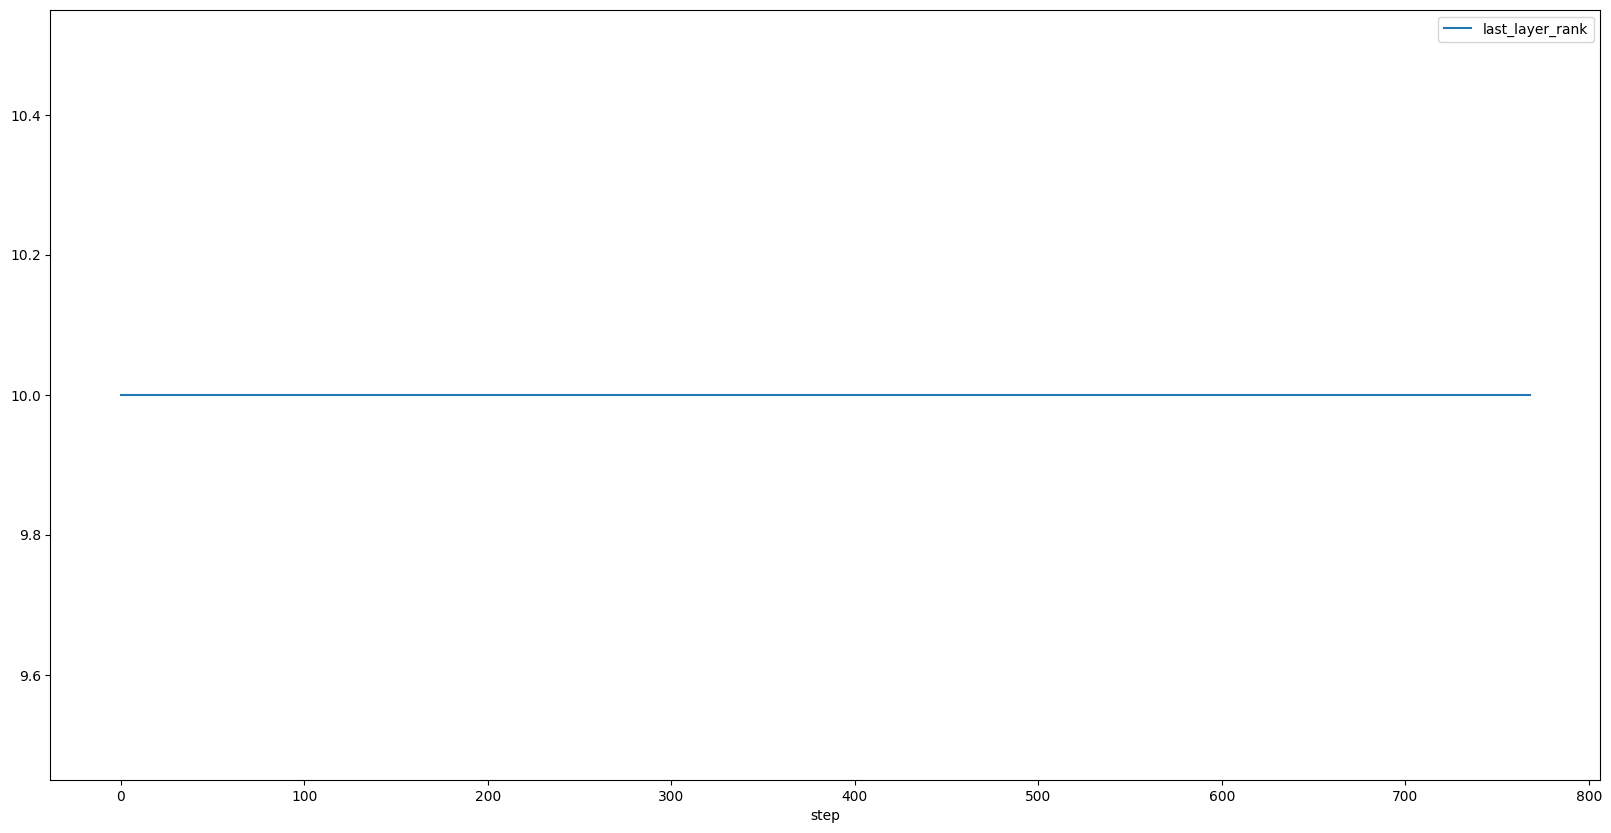

In [40]:
 measurements.plot(x="step", y="total_weight_norm", figsize=(20, 10))
 measurements.plot(x="step", y="last_layer_rank", figsize=(20, 10))